## Performance VS Size Analysis

Calculate TPFN per target then plot/averge by size?


In [1]:
import sys
import os
import logging
from math import ceil, floor
import json
from pathlib import Path
from typing import List, Tuple, Union, Dict, Optional
from multiprocessing import Process, Pool
import psutil
import base64
import asyncio
import cv2
import imageio as iio
import numpy as np
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq, fftn, fftshift
from pprint import pprint
from scipy.stats import anderson_ksamp, ks_2samp

from afdme import REPO_PATH, log
from afdme.vis import calc_tfpnr, calc_tdr, calc_frames_removed, label_to_per_frame_list
from afdme.metrics import (
    calc_box_area,
    avg_box_area,
    boxes_to_binary,
    target_detection_rate,
    tfpnr,
    safe_division,
)

[DEBUG] 03/21/2023 04:44:11PM: MainProcess: __init__.py - Loaded logging config file: /Users/nowa201/Code/fish_detector/afdme/src/afdme/logging.yaml


In [2]:
# keys for splitting and organizing loaded data


def resolve_data_split(k):
    name = k.name
    # train
    if name == "20" or name == "75" or name == "88":
        return "train"
    # test
    if name == "0" or name == "1" or name == "2":
        return "test"


def resolve_param_set(k):
    name = k.name
    if name == "20" or name == "0":
        return "20"
    if name == "75" or name == "2":
        return "75"
    if name == "88" or name == "1":
        return "88"


def resolve_color_split(split):
    if split == "train":
        return "b"
    if split == "test":
        return "o"

In [3]:
# load and organize results


def load_results(base_path, results_dict):
    split = resolve_data_split(base_path)
    param_set_name = resolve_param_set(base_path)

    # add to dictionary for reference later
    if not split in results_dict.keys():
        results_dict[split] = {param_set_name: {}}
    else:
        results_dict[split].update({param_set_name: {}})

    args_json = Path(base_path / "args.json")
    if args_json.exists():
        with open(str(args_json), "r") as f:
            log.info(json.load(f))

    # log.info("Per frame:")
    # log.info("id:, FPR, FNR, Target Detection Rate, % Frames Removed, % Neg Frames Removed")
    pos_frames, neg_frames = [], []
    pos_preds, neg_preds = [], []

    # accumulate run directories
    subdirs = next(os.walk(str(base_path)))[1]
    param_set_path = base_path
    param_set_results = []
    param_set = param_set_path.name
    # load every json for that run and append to param_set_results
    for f_name in param_set_path.glob("**/*.json"):
        with open(f_name, "r") as f:
            params = json.load(f)
            param_set_results.append((params, param_set))

    # for each video
    for result, param_set_id in param_set_results[2:]:
        # per frame binary label and pred
        binary_label, binary_pred, _ = calc_tfpnr(
            result["label"], result["prediction"], show=False, save=False
        )

        # per frame list of avg box area
        avg_box_area_per_frame = [
            avg_box_area(box) for box in label_to_per_frame_list(result["label"])
        ]

        # create list of all binary labels and preds for positive and negative frames combined with bounding boxe areas
        y = zip(binary_label, binary_pred, avg_box_area_per_frame)
        for x in y:
            if x[0] == 1:
                pos_frames.append(x)
                pos_preds.append((int(x[0] == x[1]), x[2]))
            else:
                neg_frames.append(x)
                neg_preds.append(int(x[0] == x[1]))

    results_dict[split][param_set_name]["pos_preds"] = pos_preds
    results_dict[split][param_set_name]["pos_frames"] = pos_frames
    results_dict[split][param_set_name]["neg_preds"] = neg_preds
    results_dict[split][param_set_name]["neg_frames"] = neg_frames

    # should update results_dict
    return None

In [4]:
# load the results from the base paths

base_paths = [
    Path(f"{REPO_PATH}/notebooks/outputs/with-tracklets/train/20"),
    Path(f"{REPO_PATH}/notebooks/outputs/with-tracklets/train/75"),
    Path(f"{REPO_PATH}/notebooks/outputs/with-tracklets/train/88"),
    Path(f"{REPO_PATH}/notebooks/outputs/ablation/2022-12-16/12-25-41/0"),
    Path(f"{REPO_PATH}/notebooks/outputs/ablation/2022-12-16/12-25-41/1"),
    Path(f"{REPO_PATH}/notebooks/outputs/ablation/2022-12-16/12-25-41/2"),
]

results_dict = {}
for base_path in base_paths:
    load_results(base_path, results_dict)

# verify it's full
log.info(results_dict.keys())

dict_keys(['train', 'test'])


In [5]:
# Plot bins of true/false preds


def plot_tpfn_bins(pos_preds):
    fig, ax = plt.subplots()
    true_pos_preds = [x[1] for x in pos_preds if x[0] == 1]
    false_pos_preds = [x[1] for x in pos_preds if x[0] == 0]
    ax.hist(true_pos_preds, bins=50)
    ax.hist(false_pos_preds, bins=50)


# plot_tpfn_bins(pos_preds)

In [6]:
# plot binned positive predictions with error


def plot_binned_pos_preds(pos_preds):
    # bin preds by size
    bin_size = 500
    binned_list = [[] for x in range(ceil(max([y[1] for y in pos_preds]) / bin_size))]
    for x in pos_preds:
        bin = floor(x[1] / bin_size)
        binned_list[bin].append(x)

    bin_stats = []
    for idx, bin in enumerate(binned_list):
        bin_preds = [x[0] for x in bin]
        bin_sizes = [x[1] for x in bin]
        bin_mean = np.mean(bin_preds)
        bin_std = np.std(bin_preds)
        bin_stats.append((bin_mean, bin_std, (idx * bin_size, (idx + 1) * bin_size)))

    fig, ax = plt.subplots()
    # x_start, height, width (list of 100s)
    plt.title(f"{base_path}")
    plt.bar(
        [x[2][0] for x in bin_stats],
        height=[x[0] for x in bin_stats],
        width=[bin_size for _ in bin_stats],
        yerr=[x[1] for x in bin_stats],
        ecolor="black",
        capsize=5,
    )
    # true_pos_preds = [x[1] for x in pos_preds if x[0] == 1]
    # false_pos_preds = [x[1] for x in pos_preds if x[0] == 0]
    # ax.scatter([x[1] for x in pos_preds], [x[0] for x in pos_preds], )
    # ax.hist(true_pos_preds, bins=50)
    # ax.hist(false_pos_preds, bins=50)
    # ax.set_xscale("log")


# plot_binned_pos_preds(pos_preds)

In [7]:
def resample_dist(dist, sampling):
    dist_x, dist_y = dist
    # if no values in set then its resampled CDF is all 0s? (or is it all 1s?)
    if (len(dist_x) == 0) or (len(dist_y) == 0):
        return np.zeros(len(sampling))
    else:
        return np.interp(x=sampling, xp=dist_x, fp=dist_y)


def compose_cdfs(results):
    pos_frames = results["pos_frames"]

    # organize targets data grams

    # sort all target detections by size
    sorted_pos_frames = sorted(pos_frames, key=lambda y: y[2])
    # put predictions into an array
    pos_frames_preds = np.array([x[1] for x in sorted_pos_frames])
    # put sample sizes into an array
    pos_frames_sizes = np.array([x[2] for x in sorted_pos_frames])

    # id false negative indices
    fn_idxs = np.where(pos_frames_preds == 0)[0]
    # id true positive indices
    tp_idxs = np.where(pos_frames_preds == 1)[0]

    # compose lists of tp/fn targets by size
    fn_frames = np.array([pos_frames_sizes[i] for i in fn_idxs])
    tp_frames = np.array([pos_frames_sizes[i] for i in tp_idxs])

    # calculate cdfs

    c_cdfx = pos_frames_sizes
    c_cdfy = 1.0 * np.arange(len(pos_frames_sizes)) / (len(pos_frames_sizes) - 1)

    tp_cdfx = tp_frames
    tp_cdfy = 1.0 * np.arange(len(tp_frames)) / (len(tp_frames) - 1)

    fn_cdfx = fn_frames
    fn_cdfy = 1.0 * np.arange(len(fn_frames)) / (len(fn_frames) - 1)

    # resample cdfs along same values
    n_samples = 1000
    min_val = np.min(np.hstack((c_cdfx, tp_cdfx, fn_cdfx)))
    max_val = np.max(np.hstack((c_cdfx, tp_cdfx, fn_cdfx)))
    lin_sampling = np.linspace(start=min_val, stop=max_val, num=n_samples)

    c_cdfys = resample_dist((c_cdfx, c_cdfy), lin_sampling)
    tp_cdfys = resample_dist((tp_cdfx, tp_cdfy), lin_sampling)
    fn_cdfys = resample_dist((fn_cdfx, fn_cdfy), lin_sampling)
    # c_cdfxs, c_cdfys = resample_dist((c_cdfx, c_cdfy), lin_sampling)
    # log.info(c_cdfxs)

    results.update(
        {
            "c_cdf": {
                "original": (c_cdfx, c_cdfy),
                "resampled": (lin_sampling, c_cdfys),
            },
            "tp_cdf": {
                "original": (tp_cdfx, tp_cdfy),
                "resampled": (lin_sampling, tp_cdfys),
            },
            "fn_cdf": {
                "original": (fn_cdfx, fn_cdfy),
                "resampled": (lin_sampling, fn_cdfys),
            },
        }
    )

In [8]:
for k, v in results_dict.items():
    for ki, vi in v.items():
        compose_cdfs(vi)

# are these getting filled? - yes
# log.info(results_dict['train']['20']['tp_cdf']['original'])

Anderson-Darling pvalue for tp_cdf: 0.25
Kolmogorov-Smirnov pvalue tp_cdf: 0.9232555519148353


/var/folders/bl/k8jsc_vd0mgg91nys45hryf40000gn/T/ipykernel_78347/1926263067.py:60: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([[y[2] for y in control], treatment_arr])


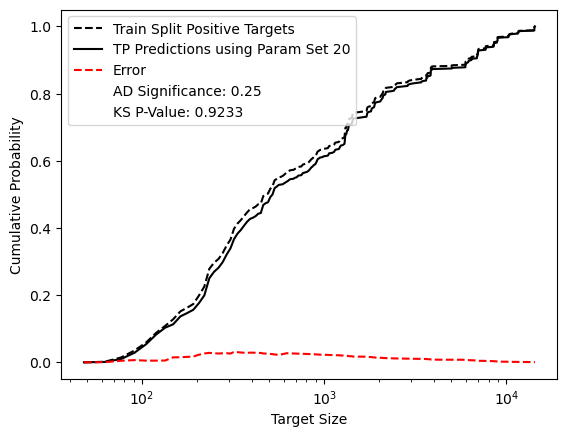

Anderson-Darling pvalue for tp_cdf: 0.25
Kolmogorov-Smirnov pvalue tp_cdf: 0.5711541585682134


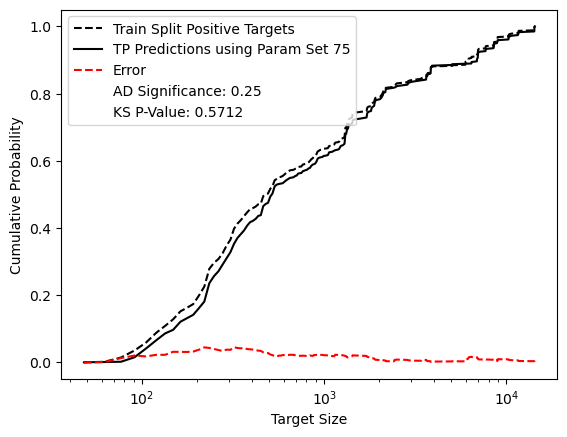

Anderson-Darling pvalue for tp_cdf: 0.001
Kolmogorov-Smirnov pvalue tp_cdf: 0.0015560821047507778


/var/folders/bl/k8jsc_vd0mgg91nys45hryf40000gn/T/ipykernel_78347/1926263067.py:60: UserWarning: p-value floored: true value smaller than 0.001
  ad = anderson_ksamp([[y[2] for y in control], treatment_arr])


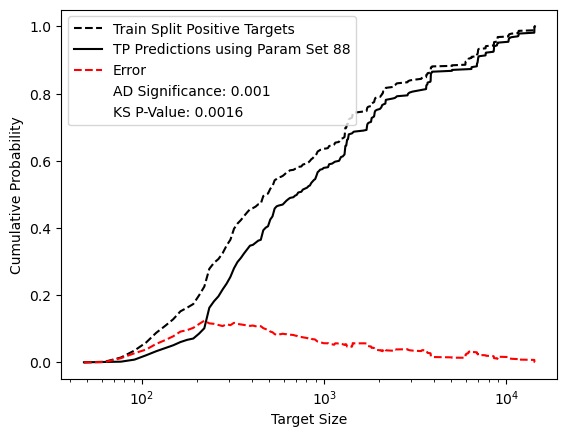

In [19]:
# plotting functions


def plot_cdf(results_dict, split, params, treatment, sampling):
    c_cdf = results_dict[split][params]["c_cdf"][sampling]
    tp_cdf = results_dict[split][params]["tp_cdf"][sampling]
    fn_cdf = results_dict[split][params]["fn_cdf"][sampling]

    if "tp" in treatment:
        label = "TP"
        t_cdf = tp_cdf
    elif "fn" in treatment:
        label = "FN"
        t_cdf = fn_cdf
    else:
        raise ValueError("Distribution is not tp or fn")

    plt.plot(*c_cdf, linestyle="dashed", color="k")
    plt.plot(*t_cdf, linestyle="solid", color="k")
    # plt.vlines([perc], ymin=0, ymax=ymax_val, linestyles='dotted', colors=resolve_color_split(base_path))
    plt.xscale("log")


def plot_cdf_err(results_dict, split, params, treatment, sampling):
    c_cdf = results_dict[split][params]["c_cdf"][sampling]
    tp_cdf = results_dict[split][params]["tp_cdf"][sampling]
    fn_cdf = results_dict[split][params]["fn_cdf"][sampling]

    if "tp" in treatment:
        label = "TP"
        t_cdf = tp_cdf
    elif "fn" in treatment:
        label = "FN"
        t_cdf = fn_cdf
    else:
        raise ValueError("Distribution is not tp or fn")

    ad, ks = test_statistics(results_dict, split, params, treatment, sampling)
    if len(c_cdf[1]) != len(t_cdf[1]):
        log.info("Not Plotting! Are the samplings of the two distributions the same?")
        plt.legend(
            [
                f"{split.capitalize()} Split Positive Targets",
                f"{label} Predictions using Param Set {params}",
            ]
        )
    else:
        err = []
        for i, _ in enumerate(c_cdf[0]):
            err.append(np.abs(c_cdf[1][i] - t_cdf[1][i]))

        plt.plot(c_cdf[0], err, linestyle="dashed", color="r")
        plt.plot([], [], " ")
        plt.plot([], [], " ")
        plt.legend(
            [
                f"{split.capitalize()} Split Positive Targets",
                f"{label} Predictions using Param Set {params}",
                "Error",
                f"AD Significance: {round(ad, 4)}",
                f"KS P-Value: {round(ks, 4)}",
            ]
        )

    plt.ylabel("Cumulative Probability")
    plt.xlabel("Target Size")
    plt.show()
    return None


def test_statistics(results_dict, split, params, treatment, sampling):
    control = results_dict[split][params]["pos_frames"]
    treatment_arr = results_dict[split][params][treatment]["original"][0]

    ad = anderson_ksamp([[y[2] for y in control], treatment_arr])
    ks = ks_2samp([y[2] for y in control], treatment_arr)
    log.info(f"Anderson-Darling pvalue for {treatment}: {ad.significance_level}")
    log.info(f"Kolmogorov-Smirnov pvalue {treatment}: {ks.pvalue}")
    return ad.significance_level, ks.pvalue


split = "train"
sampling = "resampled"

# plot_cdf((c_cdfx, c_cdfy), (tp_cdfx, tp_cdfy))
# plot_cdf((c_cdfx, c_cdfy), (fn_cdfx, fn_cdfy))
params = "20"
treatment = "tp_cdf"
plot_cdf(results_dict, split, params, treatment, sampling)
plot_cdf_err(results_dict, split, params, treatment, sampling)
# test_statistics(results_dict, split, params, treatment, sampling)

params = "75"
treatment = "tp_cdf"
plot_cdf(results_dict, split, params, treatment, sampling)
plot_cdf_err(results_dict, split, params, treatment, sampling)
# test_statistics(results_dict, split, params, treatment, sampling)

params = "88"
treatment = "tp_cdf"
plot_cdf(results_dict, split, params, treatment, sampling)
plot_cdf_err(results_dict, split, params, treatment, sampling)
# test_statistics(results_dict, split, params, treatment, sampling)

### Multirun

Plot train and test runs together


In [10]:
base_paths = [
    # Path(f"{REPO_PATH}/notebooks/outputs/with-tracklets/train/20"),
    # Path(f"{REPO_PATH}/notebooks/outputs/with-tracklets/train/75"),
    Path(f"{REPO_PATH}/notebooks/outputs/with-tracklets/train/88"),
    # Path(f"{REPO_PATH}/notebooks/outputs/ablation/2022-12-16/12-25-41/0"),
    # Path(f"{REPO_PATH}/notebooks/outputs/ablation/2022-12-16/12-25-41/1"),
    Path(f"{REPO_PATH}/notebooks/outputs/ablation/2022-12-16/12-25-41/2"),
]

In [11]:
def resolve_color_model(k):
    name = k.name
    if name == "20" or name == "0":
        return "c"
    if name == "75" or name == "1":
        return "m"
    if name == "88" or name == "2":
        return "y"


def resolve_color_split(k):
    name = k.name
    # train
    if name == "20" or name == "75" or name == "88":
        return "c"
    # test
    if name == "0" or name == "1" or name == "2":
        return "m"


def resolve_line_style(k):
    name = k.name
    # train
    if name == "20" or name == "75" or name == "88":
        return "solid"
    # test
    if name == "0" or name == "1" or name == "2":
        return "dashed"

/Users/nowa201/Software/miniconda3/envs/afdme/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nowa201/Software/miniconda3/envs/afdme/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nowa201/Software/miniconda3/envs/afdme/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/nowa201/Software/miniconda3/envs/afdme/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/nowa201/Software/miniconda3/envs/afdme/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  

[3417.0, 900.0]
2158.5


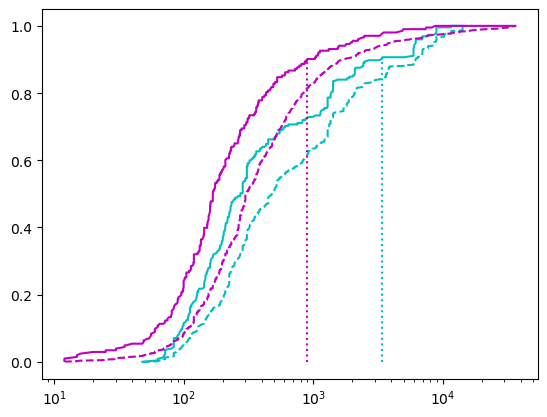

In [12]:
results = {}
percentile_values = []
for base_path in base_paths:
    args_json = Path(base_path / "args.json")
    if args_json.exists():
        with open(str(args_json), "r") as f:
            log.info(json.load(f))

    # log.info("Per frame:")
    # log.info("id:, FPR, FNR, Target Detection Rate, % Frames Removed, % Neg Frames Removed")
    pos_frames, neg_frames = [], []
    pos_preds, neg_preds = [], []

    # accumulate run directories
    subdirs = next(os.walk(str(base_path)))[1]
    param_set_path = base_path
    param_set_results = []
    param_set = param_set_path.name
    # load every json for that run and append to param_set_results
    for f_name in param_set_path.glob("**/*.json"):
        with open(f_name, "r") as f:
            params = json.load(f)
            param_set_results.append((params, param_set))

    # for each video
    for result, param_set_id in param_set_results[2:]:
        # per frame binary label and pred
        binary_label, binary_pred, _ = calc_tfpnr(
            result["label"], result["prediction"], show=False, save=False
        )

        # per frame list of avg box area
        avg_box_area_per_frame = [
            avg_box_area(box) for box in label_to_per_frame_list(result["label"])
        ]

        # create list of all binary labels and preds for positive and negative frames combined with bounding boxe areas
        y = zip(binary_label, binary_pred, avg_box_area_per_frame)
        for x in y:
            if x[0] == 1:
                pos_frames.append(x)
                pos_preds.append((int(x[0] == x[1]), x[2]))
            else:
                neg_frames.append(x)
                neg_preds.append(int(x[0] == x[1]))

    # calc erroneous detection CDF
    sorted_pos_frames = sorted(pos_frames, key=lambda y: y[2])
    ecdfx = np.array([x[2] for x in sorted_pos_frames])
    pos_frames_arr = np.array([x[1] for x in sorted_pos_frames])
    fn_idxs = np.where(pos_frames_arr == 0)[0]
    raw_ecdfy = np.zeros(len(sorted_pos_frames))
    count = 0
    for idx in fn_idxs:
        raw_ecdfy[idx] = count
        count += 1
    ecdfy = raw_ecdfy / float(len(raw_ecdfy))

    # create detection data bins
    bin_size = 500
    binned_list = [[] for x in range(ceil(max([y[1] for y in pos_preds]) / bin_size))]
    for x in pos_preds:
        bin = floor(x[1] / bin_size)
        binned_list[bin].append(x)

    # calc stats on binned data
    bin_stats = []
    for idx, bin in enumerate(binned_list):
        bin_preds = [x[0] for x in bin]
        bin_sizes = [x[1] for x in bin]
        bin_mean = np.mean(bin_preds)
        bin_std = np.std(bin_preds)
        bin_stats.append((bin_mean, bin_std, (idx * bin_size, (idx + 1) * bin_size)))

    # calc data distribution CDF
    sorted_pos_frames = sorted(pos_frames, key=lambda y: y[2])
    ecdfx = np.array([x[2] for x in sorted_pos_frames])
    ecdfy_data = np.arange(len(ecdfx)) / float(len(ecdfx))

    # calc erroneous detection CDF
    # sorted_pos_frames = sorted(pos_frames, key=lambda y: y[2])
    # ecdfx = np.array([x[2] for x in sorted_pos_frames])
    pos_frames_arr = np.array([x[1] for x in sorted_pos_frames])
    fn_idxs = np.where(pos_frames_arr == 0)[0]

    if len(fn_idxs) == 0:
        ecdfy = np.ones(len(sorted_pos_frames))
        perc = 0
        ymax_val = 1
    else:
        raw_ecdfy = np.ones(len(sorted_pos_frames)) * len(fn_idxs)
        count = 0
        cidx = 0
        for idx, _ in enumerate(raw_ecdfy):
            if (len(fn_idxs) != cidx) and (idx == fn_idxs[cidx]):
                count += 1
                raw_ecdfy[fn_idxs[cidx]] = count
                cidx += 1
            else:
                raw_ecdfy[idx] = count
        ecdfy = raw_ecdfy / float(len(fn_idxs))
        perc_idx = np.where(ecdfy > 0.9)[0][0]
        perc = ecdfx[perc_idx]
        ymax_val = 0.9
        percentile_values.append(perc)

    # plt.plot(ecdfx, ecdfy, linestyle=resolve_line_style(base_path), color=resolve_color_model(base_path))
    # plt.vlines([perc], ymin=0, ymax=ymax_val, linestyles='dotted', colors=resolve_color_model(base_path))
    # plt.xscale('log')
    plt.plot(
        ecdfx, ecdfy_data, linestyle="dashed", color=resolve_color_split(base_path)
    )
    plt.plot(ecdfx, ecdfy, linestyle="solid", color=resolve_color_split(base_path))
    plt.vlines(
        [perc],
        ymin=0,
        ymax=ymax_val,
        linestyles="dotted",
        colors=resolve_color_split(base_path),
    )
    plt.xscale("log")

    results[base_path] = bin_stats
log.info(percentile_values)
log.info(np.mean(percentile_values))

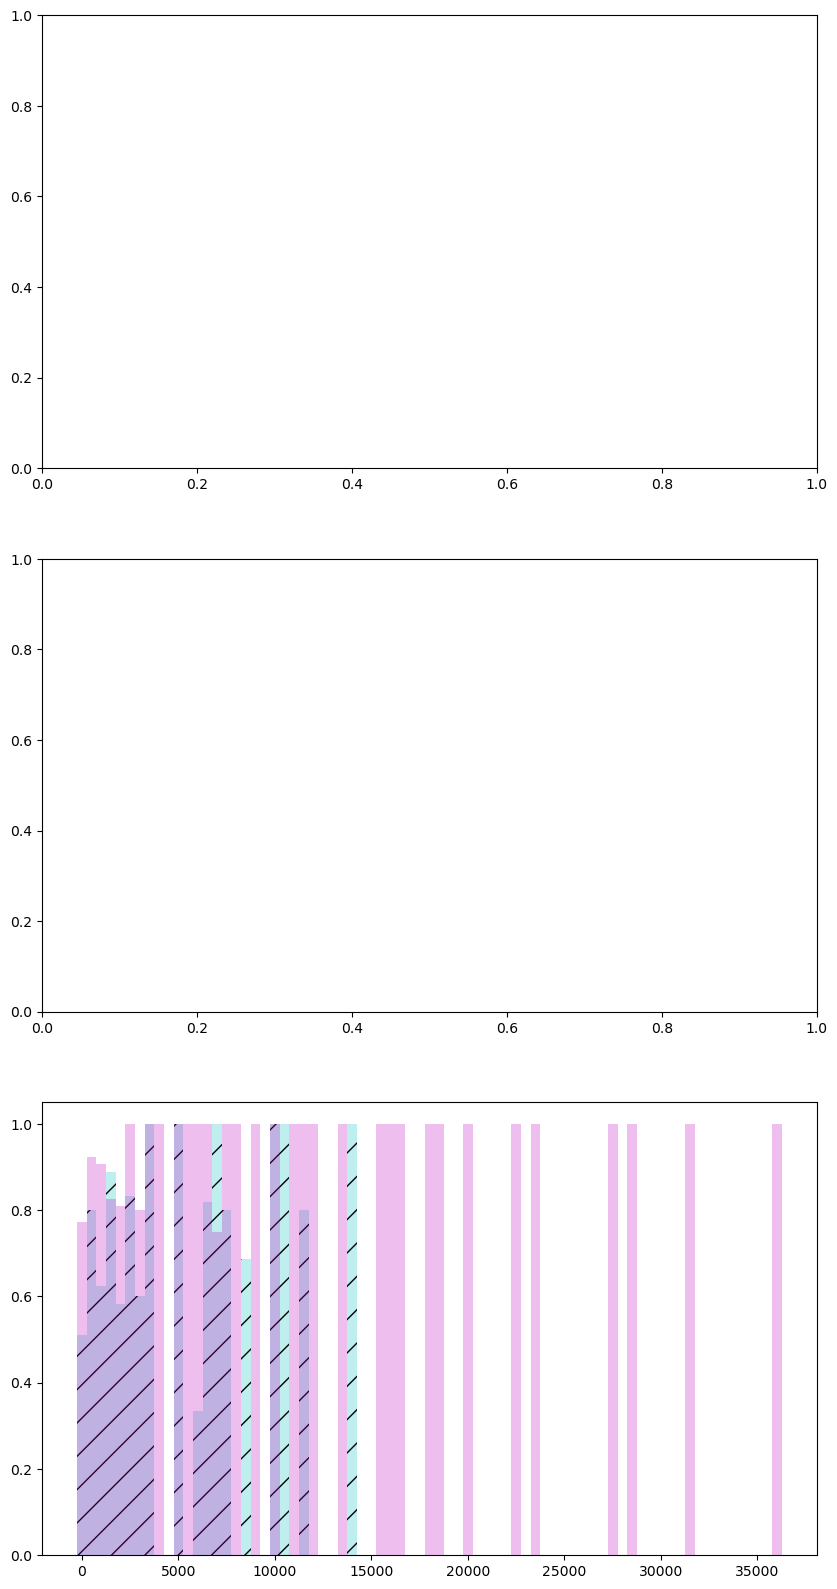

In [13]:
# x_start, height, width (list of 100s)
fig, axl = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
# plt.title(f"{base_path}")
idx = {"c": 0, "m": 1, "y": 2}
for k, v in results.items():
    axi = axl[idx[resolve_color_model(k)]]
    if "train" in str(k):
        axi.bar(
            [x[2][0] for x in v],
            height=[x[0] for x in v],
            color="c",
            alpha=0.25,
            hatch="/",
            width=[bin_size for _ in v],
        )
    else:
        axi.bar(
            [x[2][0] for x in v],
            height=[x[0] for x in v],
            color="m",
            alpha=0.25,
            width=[bin_size for _ in v],
        )

### Plot TP/FN vs. Target Size

Guiding question:

-   Does our TP rate decrease with size?


### Plot TN/FP for Train and Test

Guiding question:

-   Does our FP rate differ between the two sets? -> one contains more noise than the other
